# Paper Plots, Tables, Stats

## Sample Description

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use("opinionated_rc")

df = pd.read_parquet(
    "aligning_credit/data/files/matched-repo-contributors-to-paper-members.parquet"
)
df = df.astype({"publish_date": "datetime64[ns]"})

# Get dataframe of first row of each DOI group
df_doi_first = df.groupby("doi").first().reset_index()

print("N Unique Works (Papers and Repo Pairs):", len(df_doi_first))

N Unique Works (Papers and Repo Pairs): 4352


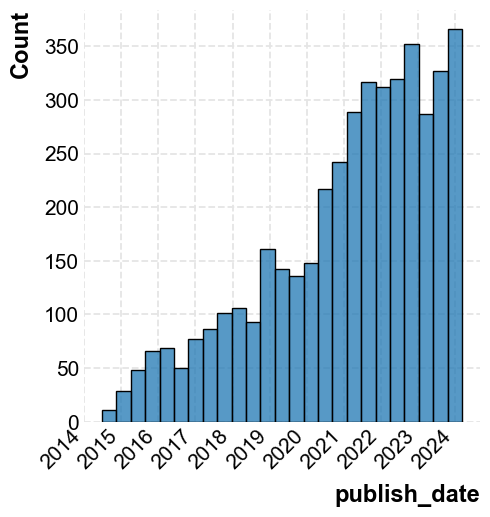

In [2]:
sns.displot(df_doi_first, x="publish_date")
_ = plt.xticks(rotation=45, ha="right")

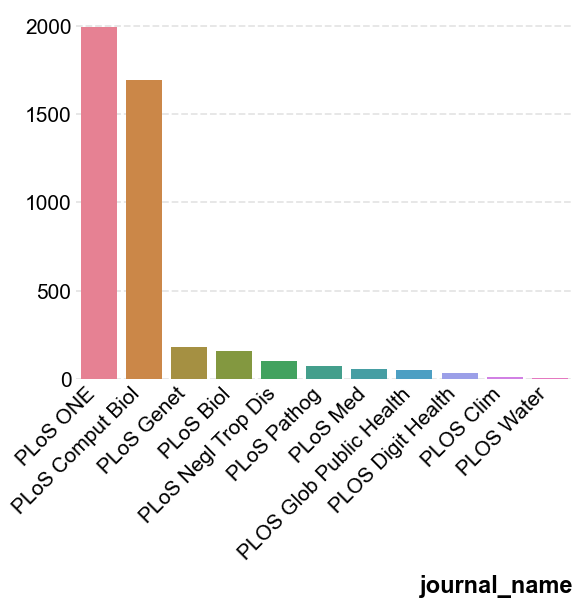

In [3]:
journal_counts = df_doi_first.journal_name.value_counts().sort_values(ascending=False)
sns.barplot(x=journal_counts.index, y=journal_counts.values, hue=journal_counts.index)
_ = plt.xticks(rotation=45, ha="right")

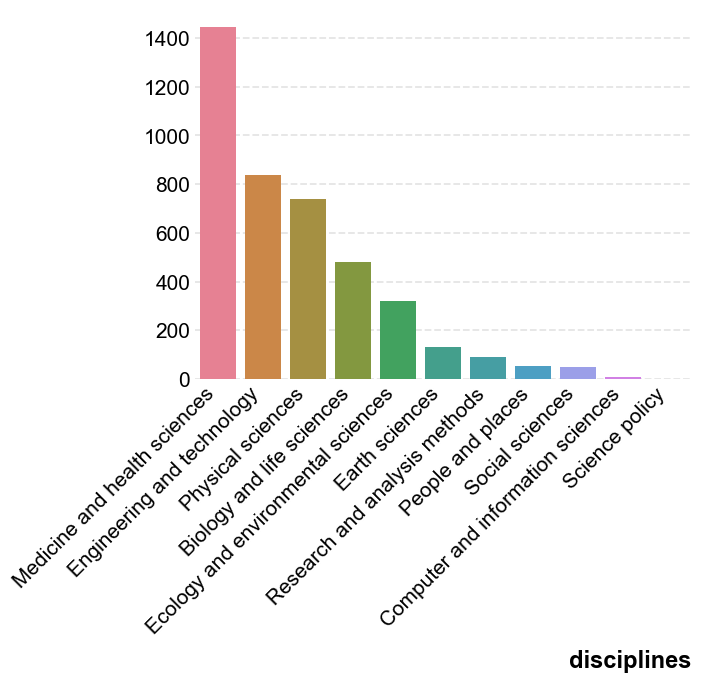

In [4]:
# Get the top level discipline for each DOI
discipline_counts = (
    df_doi_first.disciplines.apply(
        lambda x: x.split(";")[0] if isinstance(x, str) else None
    )
    .value_counts()
    .sort_values(ascending=False)
)
sns.barplot(
    x=discipline_counts.index, y=discipline_counts.values, hue=discipline_counts.index
)
_ = plt.xticks(rotation=45, ha="right")

## Authorship and Development

count                                              
                        count      mean       std  min  25%  50%  75%   max
Member Classification                                                      
Acknowledgee Only      4352.0  2.254136  4.230677  0.0  0.0  1.0  3.0  71.0
Acknowledgee-Dev       4352.0  0.075827  0.438069  0.0  0.0  0.0  0.0  17.0
Author Only            4352.0  4.333180  3.613443  0.0  2.0  3.0  6.0  32.0
Author-Dev             4352.0  1.088695  0.886291  0.0  1.0  1.0  1.0  14.0
Non-credited Dev       4352.0  0.788603  3.186659  0.0  0.0  0.0  1.0  30.0

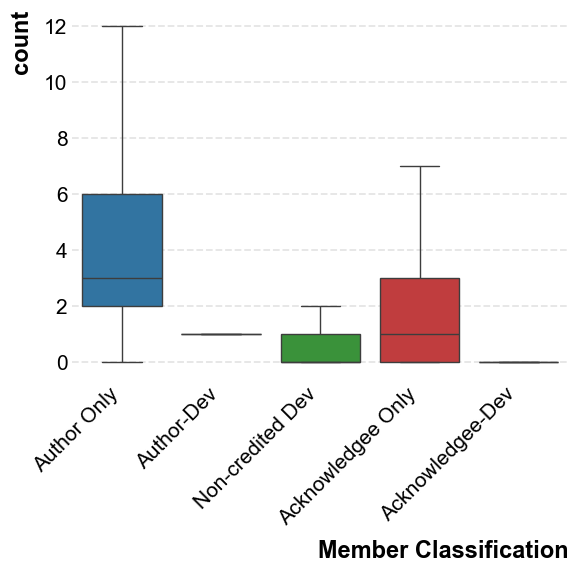

In [5]:
# For each paper (doi), get the number of authors, author-devs, and devs
per_paper_author_dev_counts = []
for doi, group in df.groupby("doi"):
    per_paper_author_dev_counts.append(
        {
            "doi": doi,
            "Author Only": len(
                group[
                    (group.known_member_dev_classification == "Known Member")
                    & (group.position.isin(["first", "middle", "last"]))
                ]
            ),
            "Author-Dev": len(
                group[
                    (
                        group.known_member_dev_classification
                        == "Known Member and Developer"
                    )
                    & (group.position.isin(["first", "middle", "last"]))
                ]
            ),
            "Non-credited Dev": len(
                group[group.known_member_dev_classification == "Developer"]
            ),
            "Acknowledgee Only": len(
                group[
                    (group.position == "acknowledgements")
                    & (group.known_member_dev_classification == "Known Member")
                ]
            ),
            "Acknowledgee-Dev": len(
                group[
                    (group.position == "acknowledgements")
                    & (
                        group.known_member_dev_classification.isin(
                            ["Known Member and Developer"]
                        )
                    )
                ]
            ),
        }
    )

df_author_dev_counts = pd.DataFrame(per_paper_author_dev_counts)

# Melt metrics
df_author_dev_counts_melted = pd.melt(
    df_author_dev_counts,
    id_vars="doi",
    value_vars=[
        "Author Only",
        "Author-Dev",
        "Non-credited Dev",
        "Acknowledgee Only",
        "Acknowledgee-Dev",
    ],
    var_name="Member Classification",
    value_name="count",
)

sns.boxplot(
    data=df_author_dev_counts_melted,
    x="Member Classification",
    y="count",
    hue="Member Classification",
    showfliers=False,
)
_ = plt.xticks(rotation=45, ha="right")

# Print describe stats (over known_member_dev_classification)
df_author_dev_counts_melted.groupby("Member Classification").describe()

#### Takeaways from Member Classification

Papers on average have:
* 4.60 author-only members (std. 3.65)
* 1.17 author-dev members (std. 0.87)
* 2.32 acknowledgees (std. 3.69)
* 0.07 acknowledgee-devs (std. 0.34)
* 1.04 non-credited devs (std. 3.64) **note:** this mean is deceiving because the max is 30, the median is 0.0

In short, this matches our expectations for _authors_, in which there are very few author-developers per paper, usually just 1 or 2.

We are surprised with how few acknowledgee-devs there are however. We expected this to follow qualitative literature which discusses how software credit is typically associated with acknowledgement sections.

This could be an artifact of our dataset however and are hoping to look into this further.

count                                              
                   count      mean       std  min  25%  50%  75%   max
Position                                                              
Acknowledgee      4352.0  0.075827  0.438069  0.0  0.0  0.0  0.0  17.0
First Author      4352.0  0.729779  0.537754  0.0  0.0  1.0  1.0   4.0
Last Author       4352.0  0.128447  0.340750  0.0  0.0  0.0  0.0   2.0
Middle Author     4352.0  0.230469  0.657653  0.0  0.0  0.0  0.0  12.0
Non-credited Dev  4352.0  0.788603  3.186659  0.0  0.0  0.0  1.0  30.0

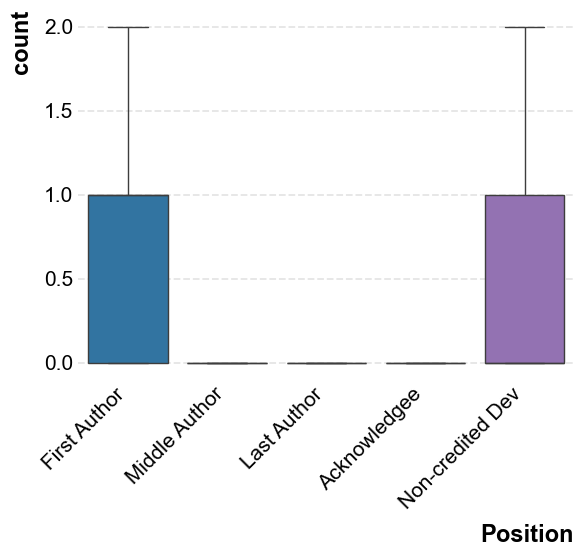

In [6]:
# For each paper (doi), get the position of where the developers are
only_devs = df.loc[
    df.known_member_dev_classification.isin(["Known Member and Developer", "Developer"])
]

per_paper_dev_positions = []
for doi, group in df.groupby("doi"):
    per_paper_dev_positions.append(
        {
            "doi": doi,
            "First Author": len(
                group[
                    (
                        group.known_member_dev_classification
                        == "Known Member and Developer"
                    )
                    & (group.position == "first")
                ]
            ),
            "Middle Author": len(
                group[
                    (
                        group.known_member_dev_classification
                        == "Known Member and Developer"
                    )
                    & (group.position == "middle")
                ]
            ),
            "Last Author": len(
                group[
                    (
                        group.known_member_dev_classification
                        == "Known Member and Developer"
                    )
                    & (group.position == "last")
                ]
            ),
            "Acknowledgee": len(
                group[
                    (group.position == "acknowledgements")
                    & (
                        group.known_member_dev_classification
                        == "Known Member and Developer"
                    )
                ]
            ),
            "Non-credited Dev": len(
                group[group.known_member_dev_classification == "Developer"]
            ),
        }
    )

dev_position_counts = pd.DataFrame(per_paper_dev_positions)

# Melt metrics
dev_position_counts_melted = pd.melt(
    dev_position_counts,
    id_vars="doi",
    value_vars=[
        "First Author",
        "Middle Author",
        "Last Author",
        "Acknowledgee",
        "Non-credited Dev",
    ],
    var_name="Position",
    value_name="count",
)

sns.boxplot(
    data=dev_position_counts_melted,
    x="Position",
    y="count",
    hue="Position",
    showfliers=False,
)
_ = plt.xticks(rotation=45, ha="right")

# Print describe stats (over known_member_dev_classification)
dev_position_counts_melted.groupby("Position").describe()

#### Takeaways from Position Inspection

On average, for an individual paper:
* first authors are also developers 77% of the time (std. 0.54)
* middle authors are also developers 24% of the time (std. 0.64)
* last authors are also developers 16% of the time (std. 0.39)
* acknowledgees are also developers 7% of the time (std. 0.34)
* non-credited devs ... **note:** should we ignore this?

We expected to see either first or middle authors are the primary developers.

Qualitative literature might suggest that middle authors are typically dev contributors but with our previous finding that on average, there is only a single dev per paper, it follows that that dev would also be the first author as the expectation for many fields is that the first author is the one who lead the experimentation (and for quantitative/computational papers, the person leading such work is typically also programming).

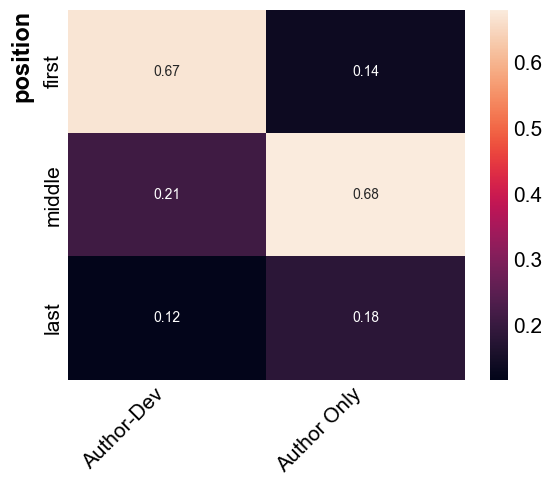

In [7]:
authors_only = df.loc[
    (
        df.known_member_dev_classification.isin(
            ["Known Member and Developer", "Known Member"]
        )
    )
    & (df.position.isin(["first", "middle", "last"]))
].copy()

proportional_positions = pd.DataFrame(
    {
        "Author-Dev": (
            authors_only.loc[
                authors_only.known_member_dev_classification
                == "Known Member and Developer"
            ].position.value_counts()
            / len(
                authors_only[
                    authors_only.known_member_dev_classification
                    == "Known Member and Developer"
                ]
            )
        ),
        "Author Only": (
            authors_only.loc[
                authors_only.known_member_dev_classification == "Known Member"
            ].position.value_counts()
            / len(
                authors_only[
                    authors_only.known_member_dev_classification == "Known Member"
                ]
            )
        ),
    }
).sort_values(by="Author-Dev", ascending=False)

sns.heatmap(proportional_positions, annot=True, fmt=".2f")
_ = plt.xticks(rotation=45, ha="right")

#### Takeaways for Position Comparison

I argue to remove this as I think the prior plot is a bit better... However it does form a nice natural comparison between author-devs and authors.

But really, imo, this just shows that most of the data follows what we would expect (as built off of the prior plot)

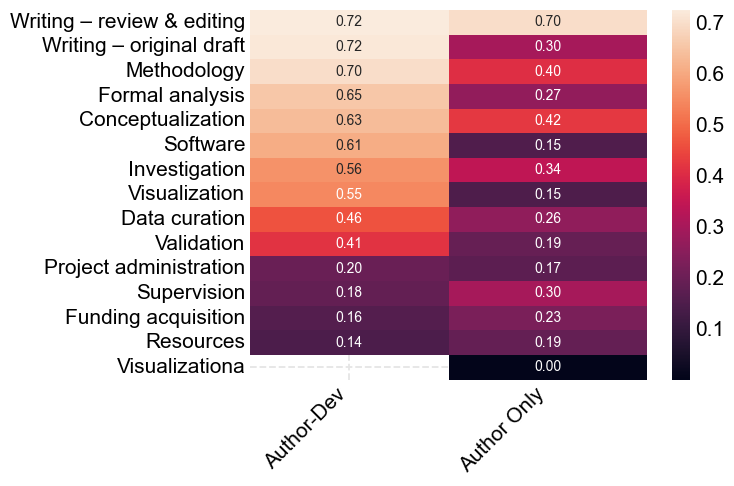

In [8]:
proportional_roles = pd.DataFrame(
    {
        "Author-Dev": (
            authors_only.loc[
                authors_only.known_member_dev_classification
                == "Known Member and Developer"
            ]
            .roles.str.get_dummies(";")
            .sum()
            / len(
                authors_only[
                    authors_only.known_member_dev_classification
                    == "Known Member and Developer"
                ]
            )
        ),
        "Author Only": (
            authors_only.loc[
                authors_only.known_member_dev_classification == "Known Member"
            ]
            .roles.str.get_dummies(";")
            .sum()
            / len(
                authors_only[
                    authors_only.known_member_dev_classification == "Known Member"
                ]
            )
        ),
    }
).sort_values(by="Author-Dev", ascending=False)

sns.heatmap(proportional_roles, annot=True, fmt=".2f")
_ = plt.xticks(rotation=45, ha="right")

#### Takeaways from Roles Comparison

I think this is interesting but only in the sense that it further aligns with our existing finding of first authors are usually the author-dev.

What we talked about previously though is also likely important / useful which is that the software, visualization, and validation roles are all very low percentages of the "Author Only" group which to me feels like our model is working well (there might be some misclassifications in there) -- if those are low (and by those i mean, activities we would expect the computational contributor to take on, then we are finding the computational contributors correctly).

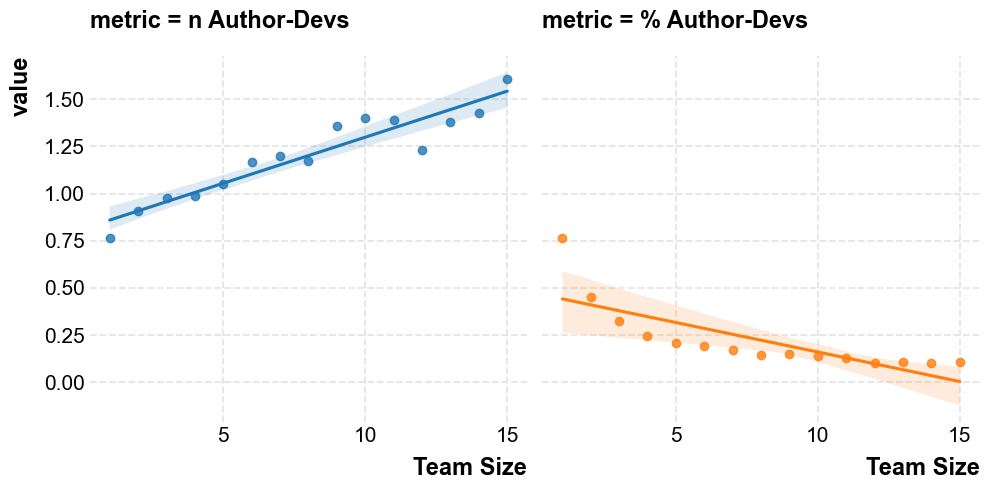

In [9]:
# Create a scatterplot with
# "Team Size ('Authors' and 'Authors and Devs')" on the x axis
# and "Number of 'Authors and Devs'" on the y axis
# Both will have to be calculated using a groupby on DOI
# and then subset to the correct author_dev_classification
# and then counted
authors_only["Team Size"] = authors_only.groupby(
    "doi"
).known_member_dev_classification.transform(
    lambda x: (x.isin(["Known Member", "Known Member and Developer"])).sum()
)
authors_only["n Author-Devs"] = authors_only.groupby(
    "doi"
).known_member_dev_classification.transform(
    lambda x: (x == "Known Member and Developer").sum()
)
authors_only["% Author-Devs"] = (
    authors_only["n Author-Devs"] / authors_only["Team Size"]
)

# Take first row of each DOI group
df_doi_first_with_team_size = authors_only.groupby("doi").first().reset_index().copy()

filtered_team_size = df_doi_first_with_team_size.loc[
    df_doi_first_with_team_size["Team Size"] <= 15
].copy()

# Take the mean of pct_authors_and_devs for each team size
team_size_mean = (
    filtered_team_size.groupby("Team Size")
    .agg(
        {
            "n Author-Devs": "mean",
            "% Author-Devs": "mean",
        }
    )
    .reset_index()
)

# Melt to make it long form
team_size_melt = team_size_mean.melt(
    id_vars="Team Size",
    value_vars=["n Author-Devs", "% Author-Devs"],
    var_name="metric",
    value_name="value",
)

sns.lmplot(team_size_melt, col="metric", x="Team Size", y="value", hue="metric")

i love this plot. the % of authors is just so sad.

I also have a theory that for team sizes less than 10, its a "small research team" who all are directly working on the project.

above that threshold might be research teams from larger institutes (allen, CIP, etc.) -- the moment you get that large, you have to make a decision about "if we want to include all the software support people in the author list"

allen inst would sometimes include everyone and sometimes not. I am going to assume that CIP doesn't include everyone (but they have data engineers)

### Other Random Notes

1. again this is a very very small subset of the data....
2. our matching model is 95% accurate / f1 -- good but room for error
3. even within our starting PLoS set, we are only accepting papers/repos which are linked in the "data availability" section. potentially more "sustainable" / "correct" teams would put the link to their data there and then link to their code somewhere else in the article text and we aren't detecting that.
4. also, it is entirely possible that certain members of acknowledgements section (or middle authors) created other repos for software tools and we are only looking at the analysis repository -- in doing so we are only seeing a subset of the "computational" contributors

even with all of this, I feel like this is a good first pass and leaves lots of areas of exploration
1. how does this look over time? is the first author dev a new development?
2. what is the distribution of contribution -- i.e. 1 members does 80% of the work?
3. how is code quality associated with the number of author-devs (more eyes makes better code)?
4. how does code quality / complexity correlate with citation?